In [1]:
import re

import numpy as np
import pandas as pd

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from baseline.config import STOP_WORDS

In [2]:
# Load PR Newswire Annotated Dataset
pr_newswire = pd.read_csv("../data/pr-newswire.csv")

In [3]:
def text_cleaning(text: str):
    """Cleans raw text input for Doc2Vec."""
    ps = PorterStemmer()
    
    # Strip punctuation and special chars
    stripped = re.sub(r"[^\w]", " ", text)
    
    # Tokenize and stem words
    tokenized = [
        ps.stem(token.lower()) for token in stripped.split(" ")
        if token.strip() and token.lower() not in STOP_WORDS
    ]
    
    return tokenized

In [4]:
raw_news_stories = pr_newswire["data"]

# Establish data and target for vectorization
stories = list(map(text_cleaning, raw_news_stories))
classifications = list(pr_newswire["target"])

In [5]:
# Build Doc2Vec `TaggedDocument` array
documents = [
    TaggedDocument(story, classifications[idx]) for idx, story in enumerate(stories)
]

In [6]:
# Build Doc2Vec model
d2v = Doc2Vec(vector_size=40, min_count=2, epochs=30)
# Build vocabulary
d2v.build_vocab(documents)

In [7]:
# Train doc2vec
d2v.train(documents, total_examples=d2v.corpus_count, epochs=d2v.epochs)

In [8]:
# Destructure words and tags from TaggedDocument
words = [doc.words for doc in documents]
tags = [doc.tags for doc in documents]

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(words, tags, test_size=0.30)

In [9]:
# Build vectors for training
x_train_vectors = [
    d2v.infer_vector(instance) for instance in x_train
]

# Build LabelEncoder for training
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# Encode training lables
y_train_labels = label_encoder.transform(np.asarray(y_train))

In [10]:
# Fit Logistic Regression on infered vectors
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train_vectors, y_train_labels)

LogisticRegression(max_iter=1000)

In [11]:
# Build vectors for testing
x_test_vectors = [
    d2v.infer_vector(instance) for instance in x_test
]

In [12]:
# Predictions
y_pred = logreg.predict(x_test_vectors)

In [13]:
# Encode test lables
y_test_labels = label_encoder.transform(y_test)

In [14]:
print(f"Classes: {logreg.classes_}")
print(f"Intercepts: {logreg.intercept_}")
print(f"Coefficient: {logreg.coef_}")

Classes: [0 1 2 3 4]
Intercepts: [-1.41067506  3.92891883 -0.53737455 -0.05683173 -1.9240375 ]
Coefficient: [[-1.30563084e-02 -1.05045021e-01  1.00970733e-01  9.91709048e-02
   7.84483780e-02  5.36846907e-02  2.59367611e-02  1.01729434e-01
  -7.58142214e-02  2.58792725e-02 -1.18023274e-01 -9.33616203e-02
   5.61946569e-02 -6.68543681e-02  1.14426246e-01  5.85409028e-03
   9.76904596e-02  9.41875141e-02  4.29296729e-02 -2.76973769e-02
   1.08347277e-01  1.28654977e-01  1.22313509e-01  5.40351542e-02
   1.49752780e-02  5.72926407e-02 -7.75495976e-02 -6.02531169e-02
   6.92806150e-02  8.09783861e-03  1.11869867e-01 -9.53878667e-02
  -1.55540984e-01  1.61787430e-01 -6.24450265e-02 -1.42481833e-02
  -1.37203319e-01  2.36043591e-01 -1.09076843e-01 -1.47313982e-02]
 [-1.44145332e-01 -4.97374134e-02  9.23633175e-03 -6.19171929e-02
   1.63984415e-01 -5.55859308e-03  1.19828374e-01 -2.47728284e-01
   4.14905819e-02 -9.28197084e-02 -2.16336105e-01  2.98381087e-04
  -9.38018773e-02  2.18726196e-01

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
)

In [16]:
c_matrix = confusion_matrix(y_test_labels, logreg.predict(x_test_vectors))

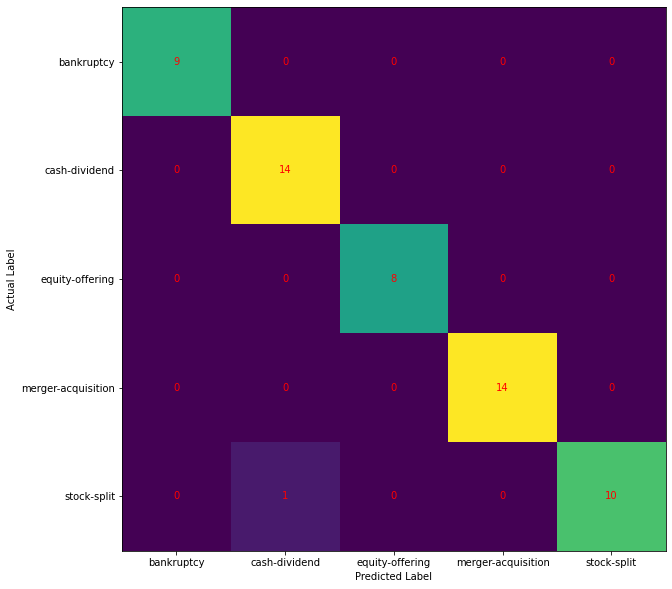

In [17]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(c_matrix)

ax.set_ylabel("Actual Label")
ax.set_xlabel("Predicted Label")
labels = tuple(label_encoder.inverse_transform([0, 1, 2, 3, 4]))
ax.xaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=labels)
ax.yaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=labels)
for i in range(len(labels)):  # ref: (https://realpython.com/logistic-regression-python/)
    for j in range(len(labels)):
        ax.text(j, i, c_matrix[i, j], ha='center', va='center', color='red')

In [18]:
# Calculate key metrics
precision = precision_score(y_test_labels, y_pred, average="weighted")
recall = recall_score(y_test_labels, y_pred, average="weighted")
f1 = f1_score(y_test_labels, y_pred, average="weighted")

print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"F1 Score: {f1}")

Precision Score: 0.9833333333333333
Recall Score: 0.9821428571428571
F1 Score: 0.982025568848229
